# Loading and Analysing Pre-Trained Sparse Autoencoders

## Imports & Installs

In [68]:
import einops
import numpy as np
import torch
from tqdm import tqdm
import plotly.express as px

# Imports for displaying vis in Colab / notebook
import webbrowser
import http.server
import socketserver
import threading

PORT = 8000

torch.set_grad_enabled(False);

## Set Up

In [87]:
# For the most part I'll try to import functions and classes near where they are used
# to make it clear where they come from.

if torch.backends.mps.is_available():
    import os
    device = "mps"
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: mps


In [3]:
def display_vis_inline(filename: str, height: int = 850):
    """
    Displays the HTML files in Colab. Uses global `PORT` variable defined in prev cell, so that each
    vis has a unique port without having to define a port within the function.
    """
    if not (COLAB):
        webbrowser.open(filename)

    else:
        global PORT

        def serve(directory):
            os.chdir(directory)

            # Create a handler for serving files
            handler = http.server.SimpleHTTPRequestHandler

            # Create a socket server with the handler
            with socketserver.TCPServer(("", PORT), handler) as httpd:
                print(f"Serving files from {directory} on port {PORT}")
                httpd.serve_forever()

        thread = threading.Thread(target=serve, args=("/content",))
        thread.start()

        output.serve_kernel_port_as_iframe(
            PORT, path=f"/{filename}", height=height, cache_in_notebook=True
        )

        PORT += 1

# Loading a pretrained Sparse Autoencoder

Below we load a Transformerlens model, a pretrained SAE and a dataset from huggingface.

In [4]:
from datasets import load_dataset
from transformer_lens import HookedTransformer
from sae_lens import SAE

model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience.
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gpt2-small-res-jb",  # see other options in sae_lens/pretrained_saes.yaml
    sae_id="blocks.8.hook_resid_pre",  # won't always be a hook point
    device=device,
)

Loaded pretrained model gpt2-small into HookedTransformer


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


blocks.8.hook_resid_pre/cfg.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

/Users/ghd/dev/MATS/NN-training/SAEs/freq-features/.venv/lib/python3.12/site-packages/sae_lens/sae.py:143: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [5]:
from transformer_lens.utils import tokenize_and_concatenate

dataset = load_dataset(
    path="NeelNanda/pile-10k",
    split="train",
    streaming=False,
)

token_dataset = tokenize_and_concatenate(
    dataset=dataset,  # type: ignore
    tokenizer=model.tokenizer,  # type: ignore
    streaming=True,
    max_length=sae.cfg.context_size,
    add_bos_token=sae.cfg.prepend_bos,
)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (229134 > 1024). Running this sequence through the model will result in indexing errors


## Basic Analysis

Let's check some basic stats on this SAE in order to see how some basic functionality in the codebase works.

We'll calculate:
- L0 (the number of features that fire per activation)
- The cross entropy loss when the output of the SAE is used in place of the activations

### L0 Test and Reconstruction Test

In [17]:
sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

with torch.no_grad():
    # activation store can give us tokens.
    batch_tokens = token_dataset[:32]["tokens"]
    _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)

    # Use the SAE
    feature_acts = sae.encode(cache[sae.cfg.hook_name])
    sae_out = sae.decode(feature_acts)

    # save some room
    del cache

    # ignore the bos token, get the number of features that activated in each token, averaged accross batch and position
    l0 = (feature_acts[:, 1:] > 0).float().sum(-1).detach()
    print("average l0", l0.mean().item())
    px.histogram(l0.flatten().cpu().numpy()).show()

average l0 68.78961944580078


Note that while the mean L0 is 64, it varies with the specific activation.

To estimate reconstruction performance, we calculate the CE loss of the model with and without the SAE being used in place of the activations. This will vary depending on the tokens.

## Calculate PCA of Activations

In [86]:
import torch
from torch.utils.data import DataLoader, TensorDataset

class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.components_ = None
        self.explained_variance = None
        self.explained_variance_ratio = None

    def fit(self, X):
        # Center the data
        self.mean = torch.mean(X, dim=0)
        X = X - self.mean

        # Compute the covariance matrix
        cov = torch.mm(X.t(), X) / (X.size(0) - 1)

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)

        # Sort eigenvectors by decreasing eigenvalues
        idx = torch.argsort(eigenvalues, descending=True)
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Store the first n_components
        self.components_ = eigenvectors[:, :self.n_components]

        # Calculate and store the proportion of variance explained
        total_variance = torch.sum(eigenvalues)
        self.explained_variance = eigenvalues[:self.n_components] 
        self.explained_variance_ratio = eigenvalues[:self.n_components] / total_variance

    def transform(self, X):
        if self.components_ is None:
            raise ValueError("PCA model has not been fitted yet. Call fit() first.")
        X = X - self.mean
        return torch.mm(X, self.components_)


In [62]:
sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

with torch.no_grad():
    # activation store can give us tokens.
    batch_tokens = token_dataset[:32]["tokens"]
    _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)

    # Use the SAE
    model_acts = cache[sae.cfg.hook_name]
    # feature_acts = sae.encode(model_acts)
    # sae_out = sae.decode(feature_acts)

    # save some room
    del cache

In [63]:

flattened_acts = einops.rearrange(model_acts, 'b s ... -> (b s) ...')
print(f"Original shape: {model_acts.shape}")
print(f"Flattened shape: {flattened_acts.shape}")

Original shape: torch.Size([32, 128, 768])
Flattened shape: torch.Size([4096, 768])


In [91]:
def get_model_acts(tokens):
    _, cache = model.run_with_cache(tokens, prepend_bos=True)
    model_acts = cache[sae.cfg.hook_name]
    del cache
    return model_acts

def fit_pca(tokens, n_components=10):

    model_acts = get_model_acts(tokens)
    flattened_acts = einops.rearrange(model_acts, 'b s ... -> (b s) ...')

    pca = PCA(n_components=n_components)
    pca.fit(flattened_acts.cpu())
    return pca


In [92]:
# Run out of memory on 128 data points
batch_tokens = token_dataset[:128]["tokens"]
pca2 = fit_pca(batch_tokens)

RuntimeError: MPS backend out of memory (MPS allocated: 17.71 GB, other allocations: 8.00 MB, max allowed: 20.40 GB). Tried to allocate 3.07 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [90]:
print(pca.explained_variance_ratio)
print(pca2.explained_variance_ratio)

tensor([0.9285, 0.0070, 0.0023, 0.0018, 0.0018, 0.0015, 0.0014, 0.0011, 0.0010,
        0.0010])

In [83]:
# Get the first principal component
first_pc = pca.components_[:, 0]

# Get the decoder weights
decoder_weights = sae.W_dec.cpu().detach().numpy()

# Calculate cosine similarity
cosine_similarities = np.dot(decoder_weights, first_pc) / (np.linalg.norm(decoder_weights, axis=1) * np.linalg.norm(first_pc))


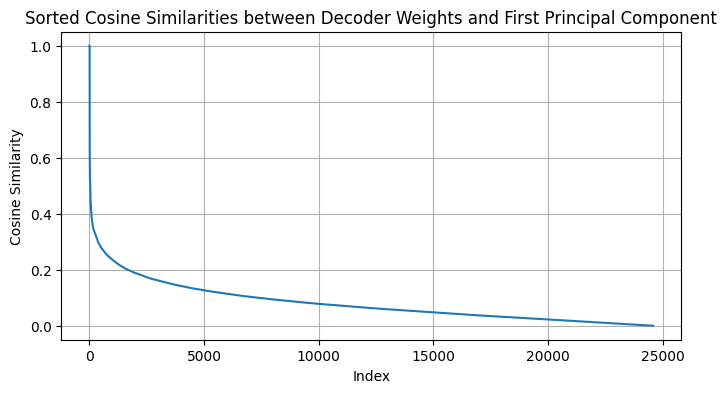

In [85]:
import matplotlib.pyplot as plt

# Sort the cosine similarities in descending order
sorted_abs_cosine_similarities = np.sort(np.abs(cosine_similarities))[::-1]

# Create a plot
plt.figure(figsize=(8, 4))
plt.plot(sorted_abs_cosine_similarities)
plt.title('Sorted Cosine Similarities between Decoder Weights and First Principal Component')
plt.xlabel('Index')
plt.ylabel('Cosine Similarity')
plt.grid(True)

# Show the plot
plt.show()

### Explore dataset size on PC results